# Mini-projet – Ensemble Learning (2025)

Ce notebook implémente les parties A et B du sujet:
- A: Chargement des données, split 70/30, analyses rapides et visualisations.
- B: Classification binaire avec arbre (Random Search) et AdaBoost (courbes, sélection, importances, temps).


In [47]:
# Optionnel: installer les dépendances manquantes (exécuter si besoin)
# Les magics %pip fonctionnent dans Jupyter et isolent l'environnement du kernel.
# Décommentez si nécessaire.
# %pip install -q pandas numpy scikit-learn matplotlib seaborn openpyxl imbalanced-learn


In [48]:
import warnings
warnings.filterwarnings("ignore")

import time
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pandas.api.types import is_numeric_dtype
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (6, 4)


## Partie A — Données: chargement, split, analyses rapides


In [49]:
# 1) Chargement du fichier Excel
path = r"C:\Users\sivas\Documents\Mini_Porjet_ML\Mini projet ensemble learning 2025\beer_quality.xlsx"
df = pd.read_excel(path)

# 2) Informations générales
n_rows, n_cols = df.shape
print("=== INFORMATIONS GÉNÉRALES ===")
print(f"Nombre de lignes : {n_rows}")
print(f"Nombre de colonnes : {n_cols}")
print("Colonnes :", list(df.columns))

# 3) Séparation X / y
y_col = "quality"
if y_col not in df.columns:
    raise ValueError("La colonne cible 'quality' est introuvable.")
X = df.drop(columns=[y_col])
y = df[y_col]

# 4) Split 70/30 (stratification grossière via binning sur y)
y_bins = pd.cut(y, bins=np.linspace(y.min(), y.max(), 6), include_lowest=True, right=True)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y_bins
)
print("\n=== SPLIT DES DONNÉES ===")
print(f"Taille X_train : {X_train.shape}")
print(f"Taille X_test  : {X_test.shape}")


=== INFORMATIONS GÉNÉRALES ===
Nombre de lignes : 1599
Nombre de colonnes : 12
Colonnes : ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']

=== SPLIT DES DONNÉES ===
Taille X_train : (1119, 11)
Taille X_test  : (480, 11)


In [50]:
# 5) Statistiques descriptives et distributions
print("\n=== STATISTIQUES DESCRIPTIVES (X_train) ===")
display(X_train.describe().T)

print("\n=== DISTRIBUTION DE y_train ===")
print(y_train.value_counts().sort_index())

print("\n=== DISTRIBUTION DE y_test ===")
print(y_test.value_counts().sort_index())

# 6) Corrélations avec la cible
corr_with_y = X_train.copy()
corr_with_y["quality"] = y_train.values
corr_series = corr_with_y.corr(numeric_only=True)["quality"].drop(labels=["quality"]).sort_values(ascending=False)
print("\n=== CORRÉLATION AVEC LA VARIABLE CIBLE ===")
print(corr_series)

print("\nTop 5 corrélations positives :")
print(corr_series.head(5))
print("\nTop 5 corrélations négatives :")
print(corr_series.tail(5))



=== STATISTIQUES DESCRIPTIVES (X_train) ===


,count,mean,std,min,25%,50%,75%,max
fixed acidity,1119.0,8.328686,1.702142,4.60000,7.20000,7.90000,9.3000,15.90000
volatile acidity,1119.0,0.529406,0.179432,0.12000,0.39250,0.53000,0.6350,1.58000
citric acid,1119.0,0.273494,0.194316,0.00000,0.10000,0.26000,0.4300,0.79000
residual sugar,1119.0,2.532887,1.367640,0.90000,1.90000,2.20000,2.6000,15.40000
chlorides,1119.0,0.088022,0.048083,0.01200,0.07000,0.07900,0.0905,0.61100
free sulfur dioxide,1119.0,16.192583,10.410288,1.00000,7.00000,14.00000,22.0000,68.00000
total sulfur dioxide,1119.0,47.302949,33.534383,6.00000,22.00000,39.00000,64.0000,289.00000
density,1119.0,0.996757,0.001832,0.99007,0.99561,0.99675,0.9978,1.00369
pH,1119.0,3.309383,0.149719,2.86000,3.21000,3.31000,3.4000,3.90000
sulphates,1119.0,0.662359,0.173035,0.39000,0.55000,0.62000,0.7400,1.98000



=== DISTRIBUTION DE y_train ===
quality
3      9
4     35
5    477
6    446
7    139
8     13
Name: count, dtype: int64

=== DISTRIBUTION DE y_test ===
quality
3      1
4     18
5    204
6    192
7     60
8      5
Name: count, dtype: int64

=== CORRÉLATION AVEC LA VARIABLE CIBLE ===
alcohol                 0.477378
sulphates               0.238821
citric acid             0.200748
fixed acidity           0.103206
residual sugar          0.020868
free sulfur dioxide    -0.039430
pH                     -0.060912
chlorides              -0.122136
density                -0.180357
total sulfur dioxide   -0.188382
volatile acidity       -0.375956
Name: quality, dtype: float64

Top 5 corrélations positives :
alcohol           0.477378
sulphates         0.238821
citric acid       0.200748
fixed acidity     0.103206
residual sugar    0.020868
Name: quality, dtype: float64

Top 5 corrélations négatives :
pH                     -0.060912
chlorides              -0.122136
density                -0.1

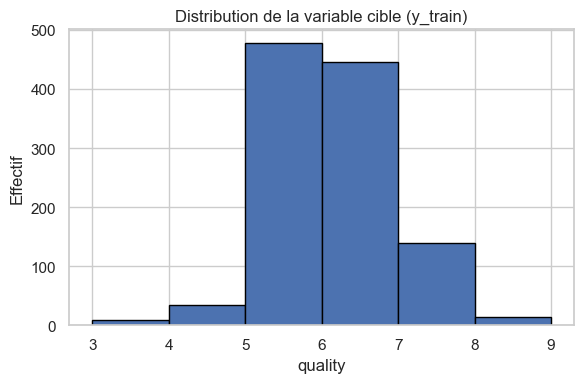

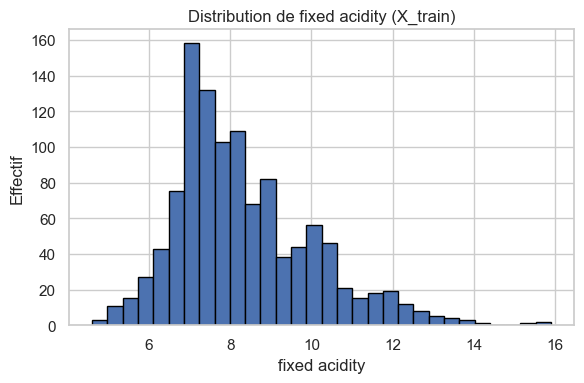

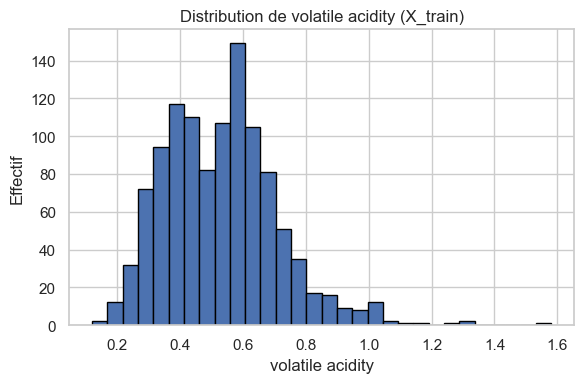

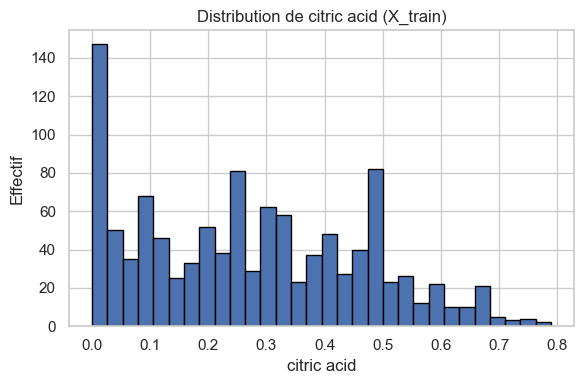

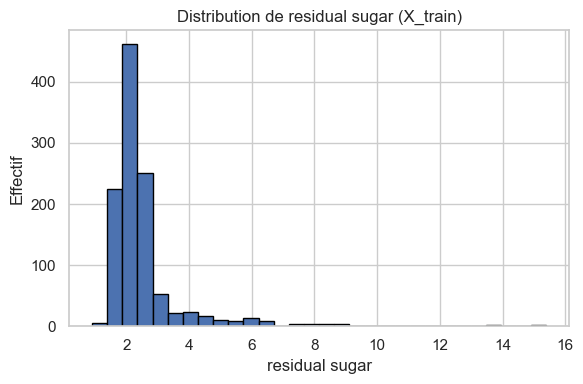

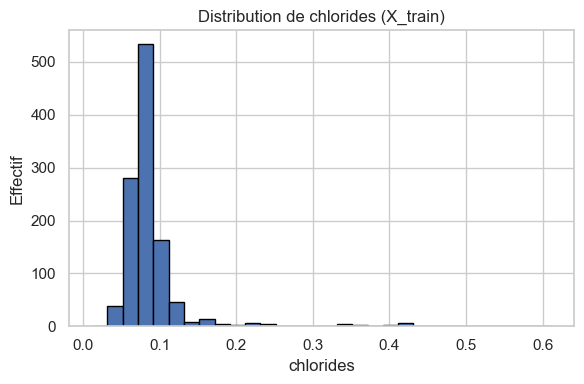

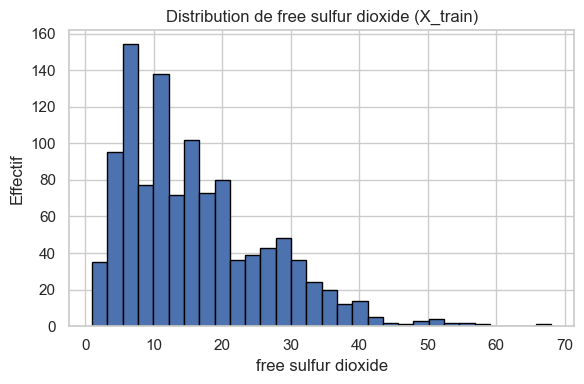

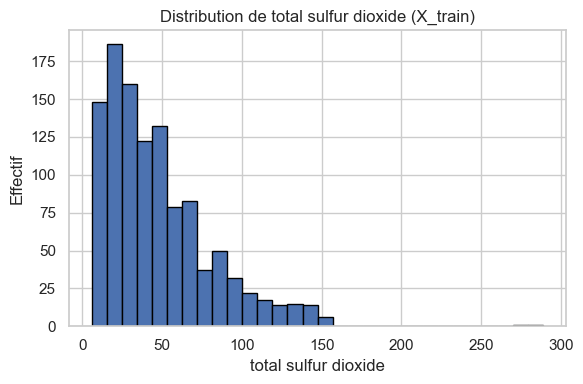

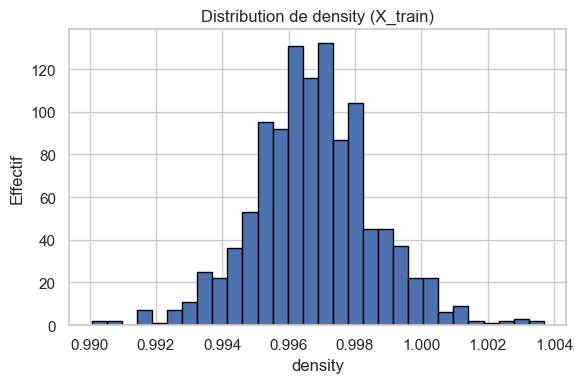

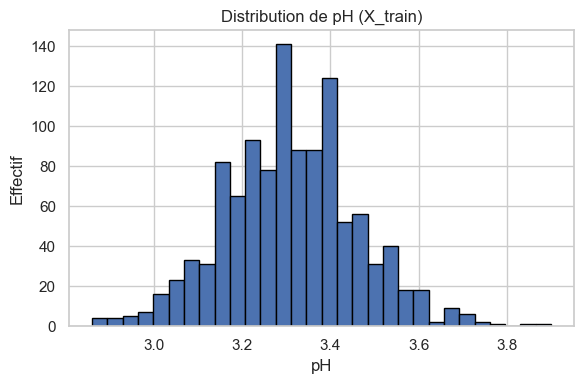

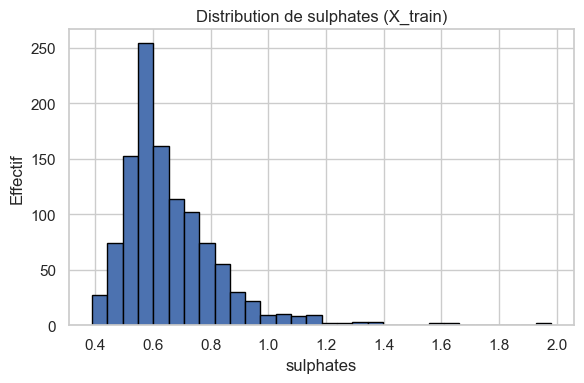

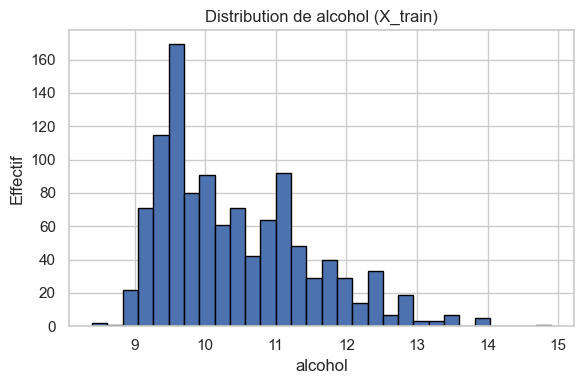

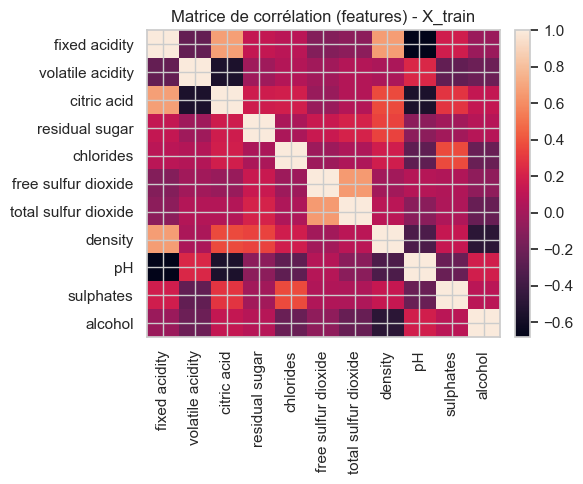

In [51]:
# 7) Visualisations de base
fig, ax = plt.subplots()
ax.hist(y_train, bins=range(int(y.min()), int(y.max()) + 2), edgecolor="black")
ax.set_title("Distribution de la variable cible (y_train)")
ax.set_xlabel("quality")
ax.set_ylabel("Effectif")
plt.tight_layout()
plt.show()

# Histogrammes des features
for col in X_train.columns:
    if is_numeric_dtype(X_train[col]):
        fig, ax = plt.subplots()
        ax.hist(X_train[col].dropna(), bins=30, edgecolor="black")
        ax.set_title(f"Distribution de {col} (X_train)")
        ax.set_xlabel(col)
        ax.set_ylabel("Effectif")
        plt.tight_layout()
        plt.show()

# Matrice de corrélations
corr_matrix = X_train.corr(numeric_only=True)
plt.figure(figsize=(6, 5))
im = plt.imshow(corr_matrix, aspect='auto')
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(ticks=range(len(corr_matrix.columns)), labels=corr_matrix.columns, rotation=90)
plt.yticks(ticks=range(len(corr_matrix.index)), labels=corr_matrix.index)
plt.title("Matrice de corrélation (features) - X_train")
plt.tight_layout()
plt.show()


## Partie B — Classification binaire (médiane)


In [52]:
# 1) Création de ybin à partir de la médiane (calculée sur y_train)
m = y_train.median()
print(f"Médiane m = {m:.3f}")

ybin_train = (y_train >= m).astype(int)
ybin_test = (y_test >= m).astype(int)
print("\nRépartition ybin_train :")
print(ybin_train.value_counts().sort_index())
print("\nRépartition ybin_test :")
print(ybin_test.value_counts().sort_index())


Médiane m = 6.000

Répartition ybin_train :
quality
0    521
1    598
Name: count, dtype: int64

Répartition ybin_test :
quality
0    223
1    257
Name: count, dtype: int64


In [53]:
# 2) Optimisation rapide d'un arbre de décision (RandomizedSearchCV)
dt = DecisionTreeClassifier(random_state=42)
param_dist = {
    "max_depth": [None] + list(range(1, 11)),
    "min_samples_split": [2, 5, 10, 20, 50],
    "min_samples_leaf": [1, 2, 5, 10, 20],
    "criterion": ["gini", "entropy", "log_loss"],
    "splitter": ["best", "random"],
}
rs = RandomizedSearchCV(
    estimator=dt,
    param_distributions=param_dist,
    n_iter=40,
    scoring="accuracy",
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=1,
)

start = time.perf_counter()
rs.fit(X_train, ybin_train)
train_time_tree = time.perf_counter() - start

best_tree = rs.best_estimator_
start = time.perf_counter()
ybin_pred_test_tree = best_tree.predict(X_test)
infer_time_tree = time.perf_counter() - start
acc_test_tree = accuracy_score(ybin_test, ybin_pred_test_tree)

print("=== Arbre de décision optimisé ===")
print("Meilleurs hyperparamètres :", rs.best_params_)
print(f"Temps apprentissage : {train_time_tree:.3f}s | Temps inférence : {infer_time_tree:.3f}s")
print(f"Accuracy test : {acc_test_tree:.4f}")

# Export LaTeX: résumé du meilleur modèle (pour \input{src/input/table_dt_randomsearch})
os.makedirs("src/input", exist_ok=True)
best_summary = pd.DataFrame([
    {
        "max_depth": rs.best_params_.get("max_depth"),
        "min_samples_split": rs.best_params_.get("min_samples_split"),
        "min_samples_leaf": rs.best_params_.get("min_samples_leaf"),
        "criterion": rs.best_params_.get("criterion"),
        "splitter": rs.best_params_.get("splitter"),
        "accuracy_test": acc_test_tree,
        "train_time_s": train_time_tree,
        "infer_time_s": infer_time_tree,
    }
])
display(best_summary)
best_summary.to_latex("src/input/table_dt_randomsearch.tex", index=False, float_format="%.4f")


Fitting 5 folds for each of 40 candidates, totalling 200 fits
=== Arbre de décision optimisé ===
Meilleurs hyperparamètres : {'splitter': 'best', 'min_samples_split': 10, 'min_samples_leaf': 10, 'max_depth': 10, 'criterion': 'entropy'}
Temps apprentissage : 3.112s | Temps inférence : 0.001s
Accuracy test : 0.6937


,max_depth,min_samples_split,min_samples_leaf,criterion,splitter,accuracy_test,train_time_s,infer_time_s
0,10,10,10,entropy,best,0.69375,3.112467,0.001179


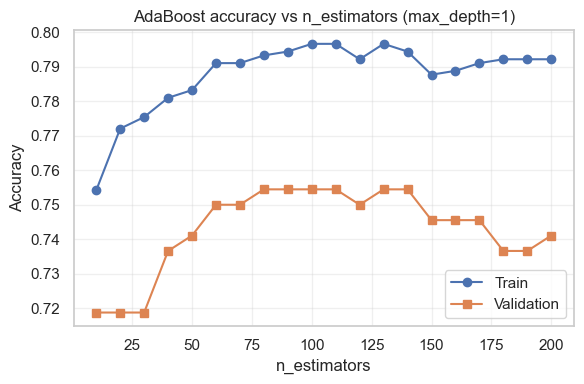

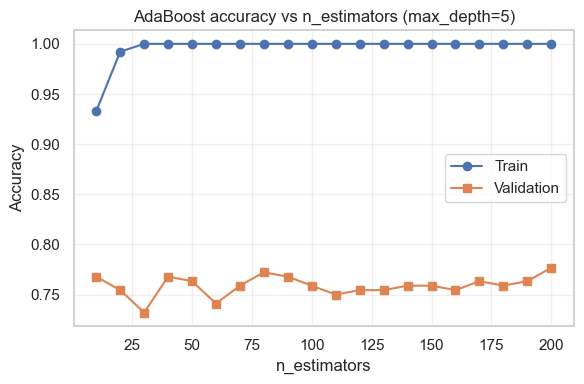

In [54]:
# 3) AdaBoost: courbes accuracy vs n_estimators (train/validation)
X_tr, X_val, ybin_tr, ybin_val = train_test_split(
    X_train, ybin_train, test_size=0.2, random_state=42, stratify=ybin_train
)

def evaluate_adaboost_over_n_estimators(max_depth_value):
    ns = list(range(10, 201, 10))
    train_accs, val_accs = [], []
    for n in ns:
        base = DecisionTreeClassifier(max_depth=max_depth_value, random_state=42)
        model = AdaBoostClassifier(
            estimator=base, n_estimators=n, algorithm="SAMME", random_state=42
        )
        model.fit(X_tr, ybin_tr)
        y_tr_pred = model.predict(X_tr)
        y_val_pred = model.predict(X_val)
        train_accs.append(accuracy_score(ybin_tr, y_tr_pred))
        val_accs.append(accuracy_score(ybin_val, y_val_pred))
    return ns, train_accs, val_accs

for depth in [1, 5]:
    ns, tr, va = evaluate_adaboost_over_n_estimators(depth)
    plt.figure()
    plt.plot(ns, tr, label="Train", marker="o")
    plt.plot(ns, va, label="Validation", marker="s")
    plt.xlabel("n_estimators")
    plt.ylabel("Accuracy")
    plt.title(f"AdaBoost accuracy vs n_estimators (max_depth={depth})")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


Config optimale: {'max_depth': 5, 'n_estimators': 200} | Accuracy validation: 0.7768

=== AdaBoost (final) ===
Temps apprentissage : 0.801s | Temps inférence : 0.035s
Accuracy test : 0.8021


,max_depth,n_estimators,accuracy_val,accuracy_test,train_time_s,infer_time_s
0,5,200,0.776786,0.802083,0.801408,0.03481



=== Importance des variables (AdaBoost) ===


total sulfur dioxide    0.107441
density                 0.105778
chlorides               0.102635
pH                      0.098377
volatile acidity        0.094320
sulphates               0.094187
alcohol                 0.093426
fixed acidity           0.082115
residual sugar          0.077687
citric acid             0.077236
free sulfur dioxide     0.066798
dtype: float64

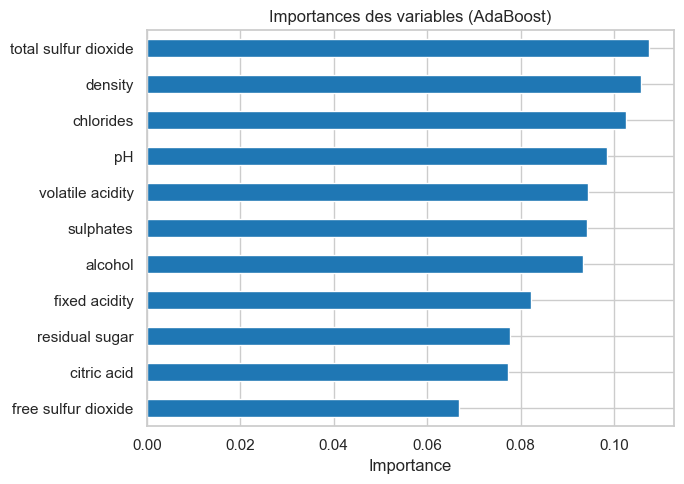


Biais/Variance:
- max_depth=1: apprenants très faibles -> biais élevé, variance faible
- max_depth=5: plus expressifs -> biais plus faible, variance plus élevée
AdaBoost réduit le biais en agrégeant de nombreux faibles apprenants, mais peut être sensible au bruit.


In [55]:
# Sélection du meilleur modèle AdaBoost sur validation, puis fit complet et test
best_score, best_cfg, best_model = -np.inf, None, None
for depth in [1, 5]:
    for n in range(10, 201, 10):
        base = DecisionTreeClassifier(max_depth=depth, random_state=42)
        model = AdaBoostClassifier(
            estimator=base, n_estimators=n, algorithm="SAMME", random_state=42
        )
        model.fit(X_tr, ybin_tr)
        val_acc = accuracy_score(ybin_val, model.predict(X_val))
        if val_acc > best_score:
            best_score = val_acc
            best_cfg = {"max_depth": depth, "n_estimators": n}
            best_model = model

print("Config optimale:", best_cfg, f"| Accuracy validation: {best_score:.4f}")

# Entraînement final sur tout X_train et évaluation test + temps
start = time.perf_counter()
final_base = DecisionTreeClassifier(max_depth=best_cfg["max_depth"], random_state=42)
final_ada = AdaBoostClassifier(
    estimator=final_base,
    n_estimators=best_cfg["n_estimators"],
    algorithm="SAMME",
    random_state=42,
)
final_ada.fit(X_train, ybin_train)
train_time_ada = time.perf_counter() - start

start = time.perf_counter()
y_test_pred_ada = final_ada.predict(X_test)
infer_time_ada = time.perf_counter() - start
acc_test_ada = accuracy_score(ybin_test, y_test_pred_ada)

print("\n=== AdaBoost (final) ===")
print(f"Temps apprentissage : {train_time_ada:.3f}s | Temps inférence : {infer_time_ada:.3f}s")
print(f"Accuracy test : {acc_test_ada:.4f}")

# Export LaTeX du meilleur modèle AdaBoost (pour \input{src/input/table_adaboost_best})
os.makedirs("src/input", exist_ok=True)
ada_summary = pd.DataFrame([
    {
        "max_depth": best_cfg["max_depth"],
        "n_estimators": best_cfg["n_estimators"],
        "accuracy_val": best_score,
        "accuracy_test": acc_test_ada,
        "train_time_s": train_time_ada,
        "infer_time_s": infer_time_ada,
    }
])
display(ada_summary)
ada_summary.to_latex("src/input/table_adaboost_best.tex", index=False, float_format="%.4f")

# Importances de variables si disponibles
if hasattr(final_ada, "feature_importances_"):
    importances = pd.Series(final_ada.feature_importances_, index=X_train.columns)
    importances = importances.sort_values(ascending=False)
    print("\n=== Importance des variables (AdaBoost) ===")
    display(importances)
    # Figure: barres horizontales et export PNG pour LaTeX
    os.makedirs("src/input", exist_ok=True)
    fig, ax = plt.subplots(figsize=(7, 5))
    importances.sort_values().plot(kind="barh", ax=ax, color="tab:blue")
    ax.set_title("Importances des variables (AdaBoost)")
    ax.set_xlabel("Importance")
    plt.tight_layout()
    plt.savefig("src/input/fig_adaboost_feature_importances.png", dpi=150)
    plt.show()
else:
    print("\nAdaBoost ne fournit pas d'importance de variables dans cette configuration.")

print("\nBiais/Variance:")
print("- max_depth=1: apprenants très faibles -> biais élevé, variance faible")
print("- max_depth=5: plus expressifs -> biais plus faible, variance plus élevée")
print("AdaBoost réduit le biais en agrégeant de nombreux faibles apprenants, mais peut être sensible au bruit.")


## Partie C — Classification multiclasse (3 classes)


In [56]:
# 1) Création de ymulti (3 classes) à partir des tertiles de y_train
# Seuils: q1 = 33%, q2 = 66% (calculés sur y_train uniquement)
q1, q2 = y_train.quantile([0.33, 0.66])
print(f"Seuils tertiles (y_train): q1={q1:.3f}, q2={q2:.3f}")

def to_ymulti(s, q1_val, q2_val):
    # 0: basse (< q1), 1: moyenne ([q1, q2)), 2: élevée (>= q2)
    out = pd.Series(index=s.index, dtype=int)
    out[s < q1_val] = 0
    out[(s >= q1_val) & (s < q2_val)] = 1
    out[s >= q2_val] = 2
    return out

ymulti_train = to_ymulti(y_train, q1, q2)
ymulti_test  = to_ymulti(y_test, q1, q2)

print("\nEffectifs (ymulti_train):")
print(ymulti_train.value_counts().sort_index())
print("\nEffectifs (ymulti_test):")
print(ymulti_test.value_counts().sort_index())

# Export LaTeX des effectifs (avant équilibrage)
os.makedirs("src/input", exist_ok=True)
counts_before = pd.DataFrame({
    "classe": [0, 1, 2],
    "train": ymulti_train.value_counts().sort_index().reindex([0,1,2]).values,
    "test": ymulti_test.value_counts().sort_index().reindex([0,1,2]).values,
})
display(counts_before)
counts_before.to_latex("src/input/table_ymulti_counts.tex", index=False)


Seuils tertiles (y_train): q1=5.000, q2=6.000

Effectifs (ymulti_train):
0.0     44
1.0    477
2.0    598
Name: count, dtype: int64

Effectifs (ymulti_test):
0.0     19
1.0    204
2.0    257
Name: count, dtype: int64


,classe,train,test
0,0,44,19
1,1,477,204
2,2,598,257


In [57]:
# 2) Équilibrage des classes sur l'apprentissage (SMOTE)
# On applique SMOTE uniquement sur (X_train, ymulti_train)
# Attention: SMOTE nécessite >= k_neighbors+1 exemples par classe; si problème, baisser k_neighbors.
smote = SMOTE(random_state=42)
X_train_sm, ymulti_train_sm = smote.fit_resample(X_train, ymulti_train)

print("Effectifs après SMOTE (apprentissage):")
print(pd.Series(ymulti_train_sm).value_counts().sort_index())

# Export LaTeX des effectifs équilibrés
counts_after = pd.DataFrame({
    "classe": [0, 1, 2],
    "train_SMOTE": pd.Series(ymulti_train_sm).value_counts().sort_index().reindex([0,1,2]).values,
})
display(counts_after)
counts_after.to_latex("src/input/table_ymulti_counts_balanced.tex", index=False)


Effectifs après SMOTE (apprentissage):
0.0    598
1.0    598
2.0    598
Name: count, dtype: int64


,classe,train_SMOTE
0,0,598
1,1,598
2,2,598


### Partie1C — Réseau de neurones (1 couche cachée), early stopping, F1-macro, matrices de confusion


Meilleur MLP (déséquilibré): {'hidden_layer_sizes': (64,), 'alpha': 0.0001, 'learning_rate_init': 0.0005, 'note': 'imbalanced'} | F1-macro val: 0.40488092604880926
Meilleur MLP (SMOTE): {'hidden_layer_sizes': (64,), 'alpha': 0.001, 'learning_rate_init': 0.001, 'note': 'SMOTE'} | F1-macro val: 0.6044791663927844

=== MLP imbalanced — Test ===
F1-macro: 0.3720177948522987


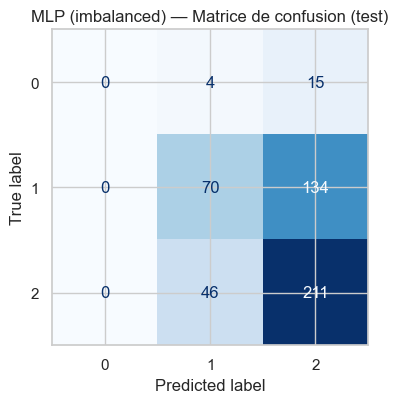


=== MLP SMOTE — Test ===
F1-macro: 0.4227286264662165


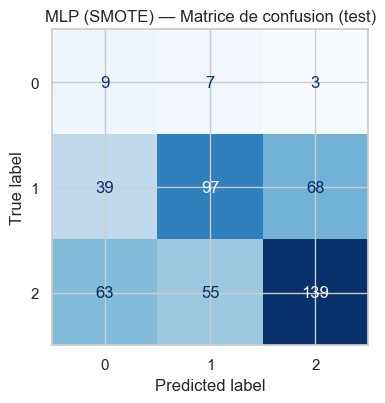

In [58]:
# Split validation pour la sélection des hyperparamètres (déséquilibré)
X_tr_m, X_val_m, y_tr_m, y_val_m = train_test_split(
    X_train, ymulti_train, test_size=0.2, random_state=42, stratify=ymulti_train
)

# Split validation pour les données équilibrées (SMOTE)
X_tr_sm, X_val_sm, y_tr_sm, y_val_sm = train_test_split(
    X_train_sm, ymulti_train_sm, test_size=0.2, random_state=42, stratify=ymulti_train_sm
)

# Recherche rapide d'hyperparamètres (F1-macro) avec early stopping
param_grid = [
    {"hidden_layer_sizes": [(32,), (64,), (32,16)], "alpha": [1e-4, 1e-3], "learning_rate_init": [1e-3, 5e-4]},
]

def tune_mlp(X_tr, y_tr, X_val, y_val, note):
    best_score, best_cfg, best_model = -np.inf, None, None
    for hls in [(32,), (64,), (32,16)]:
        for alpha in [1e-4, 1e-3]:
            for lr in [1e-3, 5e-4]:
                clf = MLPClassifier(
                    hidden_layer_sizes=hls,
                    activation="relu",
                    solver="adam",
                    alpha=alpha,
                    learning_rate_init=lr,
                    early_stopping=True,
                    n_iter_no_change=10,
                    max_iter=400,
                    random_state=42,
                )
                clf.fit(X_tr, y_tr)
                f1_val = f1_score(y_val, clf.predict(X_val), average="macro")
                if f1_val > best_score:
                    best_score = f1_val
                    best_cfg = {"hidden_layer_sizes": hls, "alpha": alpha, "learning_rate_init": lr, "note": note}
                    best_model = clf
    return best_score, best_cfg, best_model

f1_imb, cfg_imb, mlp_imb = tune_mlp(X_tr_m, y_tr_m, X_val_m, y_val_m, note="imbalanced")
f1_bal, cfg_bal, mlp_bal = tune_mlp(X_tr_sm, y_tr_sm, X_val_sm, y_val_sm, note="SMOTE")

print("Meilleur MLP (déséquilibré):", cfg_imb, "| F1-macro val:", f1_imb)
print("Meilleur MLP (SMOTE):", cfg_bal, "| F1-macro val:", f1_bal)

# Évaluation finale sur test pour les deux cas
for name, model in [("imbalanced", mlp_imb), ("SMOTE", mlp_bal)]:
    y_pred_test = model.predict(X_test)
    print(f"\n=== MLP {name} — Test ===")
    print("F1-macro:", f1_score(ymulti_test, y_pred_test, average="macro"))
    # Matrices de confusion + export figures
    os.makedirs("src/input", exist_ok=True)
    fig, ax = plt.subplots(figsize=(4.8, 4.2))
    ConfusionMatrixDisplay(confusion_matrix(ymulti_test, y_pred_test)).plot(ax=ax, cmap="Blues", colorbar=False)
    ax.set_title(f"MLP ({name}) — Matrice de confusion (test)")
    plt.tight_layout()
    out = f"src/input/fig_mlp_confusion_{name.lower()}.png"
    plt.savefig(out, dpi=150)
    plt.show()


### C.4 — Bagging avec MLP (base learner), F1 vs n_estimators


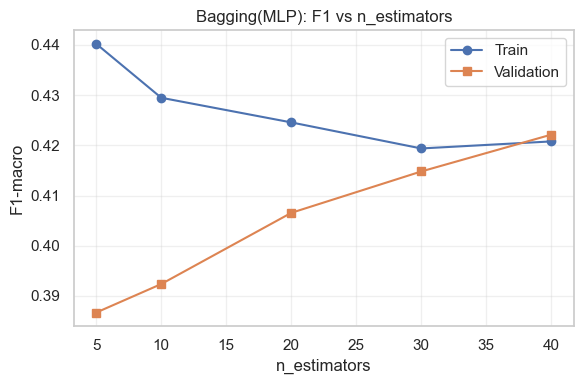

Meilleur n_estimators (val): 40 | F1 val: 0.4221322184478704
F1-macro test (bagging MLP, déséquilibré): 0.37364333092758706
Biais/Variance:
- Augmenter n_estimators réduit la variance (agrégation) mais peut saturer en biais si le base learner est biaisé.


In [59]:
# On utilise comme base le meilleur MLP (déséquilibré) pour éviter un coût excessif
base_mlp = MLPClassifier(
    hidden_layer_sizes=cfg_imb["hidden_layer_sizes"],
    activation="relu",
    solver="adam",
    alpha=cfg_imb["alpha"],
    learning_rate_init=cfg_imb["learning_rate_init"],
    early_stopping=True,
    n_iter_no_change=10,
    max_iter=400,
    random_state=42,
)

ns = [5, 10, 20, 30, 40]
train_f1s, val_f1s = [], []
for n in ns:
    bag = BaggingClassifier(
        estimator=base_mlp,
        n_estimators=n,
        max_samples=1.0,
        max_features=1.0,
        bootstrap=True,
        random_state=42,
        n_jobs=-1,
    )
    bag.fit(X_tr_m, y_tr_m)
    y_tr_pred = bag.predict(X_tr_m)
    y_val_pred = bag.predict(X_val_m)
    train_f1s.append(f1_score(y_tr_m, y_tr_pred, average="macro"))
    val_f1s.append(f1_score(y_val_m, y_val_pred, average="macro"))

plt.figure()
plt.plot(ns, train_f1s, marker="o", label="Train")
plt.plot(ns, val_f1s, marker="s", label="Validation")
plt.xlabel("n_estimators")
plt.ylabel("F1-macro")
plt.title("Bagging(MLP): F1 vs n_estimators")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
os.makedirs("src/input", exist_ok=True)
plt.savefig("src/input/fig_bagging_mlp_f1.png", dpi=150)
plt.show()

# Sélection du meilleur n_estimators sur validation
best_idx = int(np.argmax(val_f1s))
best_n = ns[best_idx]
print("Meilleur n_estimators (val):", best_n, "| F1 val:", val_f1s[best_idx])

# Fit final sur X_train et test
bag_best = BaggingClassifier(
    estimator=base_mlp,
    n_estimators=best_n,
    bootstrap=True,
    random_state=42,
    n_jobs=-1,
)
bag_best.fit(X_train, ymulti_train)
print("F1-macro test (bagging MLP, déséquilibré):", f1_score(ymulti_test, bag_best.predict(X_test), average="macro"))

print("Biais/Variance:")
print("- Augmenter n_estimators réduit la variance (agrégation) mais peut saturer en biais si le base learner est biaisé.")


### Partie 2C — Forêt aléatoire: F1 vs n_estimators, random search, importances


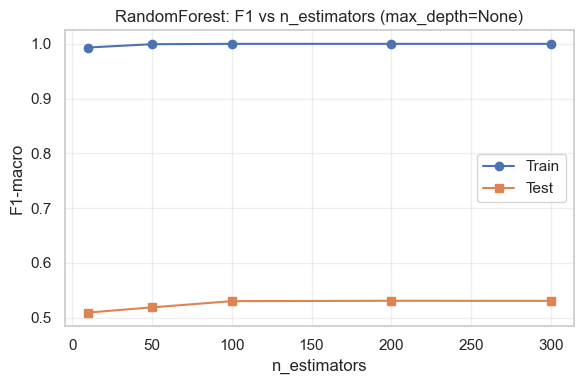

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Meilleurs hyperparamètres RF: {'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 20}
F1-macro train: 0.9872594700852275
F1-macro test: 0.5166056166056165


,n_estimators,min_samples_split,min_samples_leaf,max_features,max_depth,f1_train,f1_test,train_time_s
0,400,5,1,None,20,0.987259,0.516606,11.955603


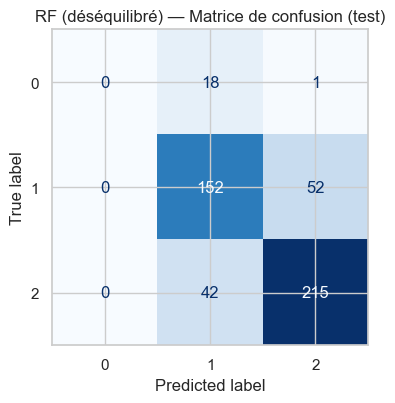

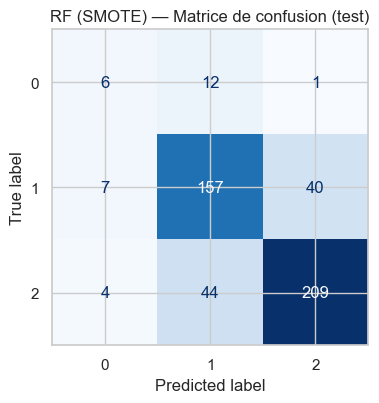


Top importances RF:


alcohol                 0.259890
sulphates               0.116543
total sulfur dioxide    0.107987
volatile acidity        0.103562
chlorides               0.070270
pH                      0.066861
fixed acidity           0.064819
residual sugar          0.057278
density                 0.055519
citric acid             0.049740
free sulfur dioxide     0.047533
dtype: float64

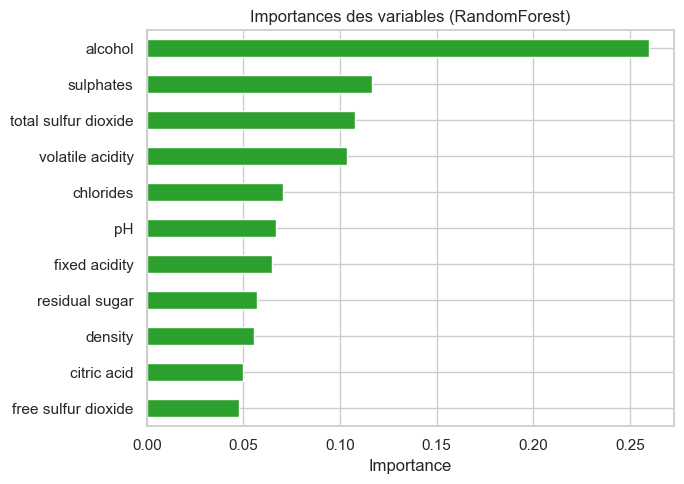


Biais/Variance:
- RF avec n_estimators élevé réduit la variance (bagging) et contrôle le biais via la profondeur.
- Par rapport à AdaBoost (B.3), RF peut mieux gérer le bruit et fournit des importances stables.


In [60]:
# Courbe F1 vs n_estimators (max_depth=None) en apprentissage et test
ns = [10, 50, 100, 200, 300]
train_f1s, test_f1s = [], []
for n in ns:
    rf = RandomForestClassifier(n_estimators=n, max_depth=None, random_state=42, n_jobs=-1)
    rf.fit(X_train, ymulti_train)
    train_f1s.append(f1_score(ymulti_train, rf.predict(X_train), average="macro"))
    test_f1s.append(f1_score(ymulti_test, rf.predict(X_test), average="macro"))

plt.figure()
plt.plot(ns, train_f1s, marker="o", label="Train")
plt.plot(ns, test_f1s, marker="s", label="Test")
plt.xlabel("n_estimators")
plt.ylabel("F1-macro")
plt.title("RandomForest: F1 vs n_estimators (max_depth=None)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
os.makedirs("src/input", exist_ok=True)
plt.savefig("src/input/fig_rf_f1_curve.png", dpi=150)
plt.show()

# Random search sur max_depth et n_estimators (F1-macro)
param_dist = {
    "n_estimators": [50, 100, 150, 200, 300, 400],
    "max_depth": [None, 5, 10, 15, 20, 30],
    "max_features": ["sqrt", "log2", None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
}
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
rs = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=30,
    scoring="f1_macro",
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=1,
)
start = time.perf_counter()
rs.fit(X_train, ymulti_train)
train_time_rf = time.perf_counter() - start
rf_best = rs.best_estimator_

# Perf en apprentissage et test + confusion matrices (déséquilibré)
y_pred_train = rf_best.predict(X_train)
y_pred_test = rf_best.predict(X_test)
print("Meilleurs hyperparamètres RF:", rs.best_params_)
print("F1-macro train:", f1_score(ymulti_train, y_pred_train, average="macro"))
print("F1-macro test:", f1_score(ymulti_test, y_pred_test, average="macro"))

# Export LaTeX résumé best RF
best_rf_summary = pd.DataFrame([
    {
        **rs.best_params_,
        "f1_train": f1_score(ymulti_train, y_pred_train, average="macro"),
        "f1_test": f1_score(ymulti_test, y_pred_test, average="macro"),
        "train_time_s": train_time_rf,
    }
])
display(best_rf_summary)
best_rf_summary.to_latex("src/input/table_rf_randomsearch.tex", index=False, float_format="%.4f")

# Confusion matrices RF (déséquilibré vs équilibré)
fig, ax = plt.subplots(figsize=(4.8, 4.2))
ConfusionMatrixDisplay(confusion_matrix(ymulti_test, y_pred_test)).plot(ax=ax, cmap="Blues", colorbar=False)
ax.set_title("RF (déséquilibré) — Matrice de confusion (test)")
plt.tight_layout()
plt.savefig("src/input/fig_rf_confusion_imbalanced.png", dpi=150)
plt.show()

# Fit RF sur données équilibrées (SMOTE) et test
rf_sm = RandomForestClassifier(**rs.best_params_, random_state=42, n_jobs=-1)
rf_sm.fit(X_train_sm, ymulti_train_sm)
y_pred_test_sm = rf_sm.predict(X_test)
fig, ax = plt.subplots(figsize=(4.8, 4.2))
ConfusionMatrixDisplay(confusion_matrix(ymulti_test, y_pred_test_sm)).plot(ax=ax, cmap="Blues", colorbar=False)
ax.set_title("RF (SMOTE) — Matrice de confusion (test)")
plt.tight_layout()
plt.savefig("src/input/fig_rf_confusion_smote.png", dpi=150)
plt.show()

# Importances des variables et comparaison avec B.3
importances = pd.Series(rf_best.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print("\nTop importances RF:")
display(importances)
fig, ax = plt.subplots(figsize=(7, 5))
importances.sort_values().plot(kind="barh", ax=ax, color="tab:green")
ax.set_title("Importances des variables (RandomForest)")
ax.set_xlabel("Importance")
plt.tight_layout()
plt.savefig("src/input/fig_rf_feature_importances.png", dpi=150)
plt.show()

print("\nBiais/Variance:")
print("- RF avec n_estimators élevé réduit la variance (bagging) et contrôle le biais via la profondeur.")
print("- Par rapport à AdaBoost (B.3), RF peut mieux gérer le bruit et fournit des importances stables.")
